In [1]:
import numpy as np
np.random.seed(42)
import pandas as pd
import hts

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter("ignore")

# settings
plt.style.use('seaborn')
plt.rcParams["figure.figsize"] = (16, 8)

import pickle

In [2]:
df = pd.read_excel('../HCP_Data_KDAG_Hackathon.xlsx', parse_dates=['Time_Period'])
df.head()

,Physician_ID,Time_Period,Brand_Rx,Market_Rx,Sales_Rep_Calls,Samples_Dropped,Physician_Segment,Emails_Delivered,Speaker_Programs_Attended,Vouchers_Dropped,Specialty
0,axt00001,2019-01-04,0.0,2.80567,1,0,3-Low,0,0,0,Dermatologist
1,axt00001,2019-01-11,0.0,20.57312,1,0,3-Low,0,0,0,Dermatologist
2,axt00001,2019-01-18,0.0,6.16010,1,0,3-Low,0,0,0,Dermatologist
3,axt00001,2019-01-25,0.0,8.95501,1,5,3-Low,0,0,0,Dermatologist
4,axt00001,2019-02-01,0.0,9.13793,1,0,3-Low,0,0,0,Dermatologist


In [3]:
df.nunique()

Physician_ID                 10000
Time_Period                     57
Brand_Rx                      8699
Market_Rx                    20766
Sales_Rep_Calls                  2
Samples_Dropped                 81
Physician_Segment                3
Emails_Delivered                 9
Speaker_Programs_Attended        3
Vouchers_Dropped                20
Specialty                        3
dtype: int64

In [4]:
df = df.drop(['Speaker_Programs_Attended', 'Vouchers_Dropped'], axis=1)
df = df[['Physician_ID', 'Time_Period', 'Physician_Segment', 'Specialty', 'Sales_Rep_Calls', 'Samples_Dropped', 'Emails_Delivered', 'Brand_Rx', 'Market_Rx']]
# df['Percent_Market_Share'] = df['Brand_Rx'] / df['Market_Rx'] * 100.0
df['Specialty'] = df['Specialty'].map({'Dermatologist':'D', 'General Physician':'GP', 'Nurse Practitioner':'NP'})
df['Physician_Segment'] = df['Physician_Segment'].map({'3-Low':'L', '2-Medium':'M', '1-High':'H'})
df.head()

,Physician_ID,Time_Period,Physician_Segment,Specialty,Sales_Rep_Calls,Samples_Dropped,Emails_Delivered,Brand_Rx,Market_Rx
0,axt00001,2019-01-04,L,D,1,0,0,0.0,2.80567
1,axt00001,2019-01-11,L,D,1,0,0,0.0,20.57312
2,axt00001,2019-01-18,L,D,1,0,0,0.0,6.16010
3,axt00001,2019-01-25,L,D,1,5,0,0.0,8.95501
4,axt00001,2019-02-01,L,D,1,0,0,0.0,9.13793


In [5]:
out_dict = {'Sales_Rep_Calls':0, 'Samples_Dropped':1, 'Emails_Delivered':2}

In [6]:
# Number of weeks when Sales_Rep_Calls, Samples_Dropped, Emails_Delivered are all 0
df[['Sales_Rep_Calls', 'Samples_Dropped', 'Emails_Delivered']].apply(lambda x: (x!=0).sum(), axis=1).value_counts()

0    293932
1    185224
2     78213
3     12631
dtype: int64

In [7]:
# Number of high segment HCPs
print(df[df['Physician_Segment']=='H']['Physician_ID'].nunique())
# Number of medium segment HCPs
print(df[df['Physician_Segment']=='M']['Physician_ID'].nunique())
# Number of low segment HCPs
print(df[df['Physician_Segment']=='L']['Physician_ID'].nunique())

2276
3286
4438


In [8]:
# create the bottom level id
df["seg_specialty_id"] = df.apply(lambda x: f"{x['Physician_Segment']}_{x['Specialty']}_{x['Physician_ID']}", axis=1)
# create the l1 level id
df["seg_specialty"] = df.apply(lambda x: f"{x['Physician_Segment']}_{x['Specialty']}", axis=1)

In [9]:
# create the bottom level df
df_bottom_level = df.pivot(index="Time_Period", columns="seg_specialty_id", values="Brand_Rx")
df_bottom_level.head()

seg_specialty_id,H_D_axt00005,H_D_axt00006,H_D_axt00007,H_D_axt00010,H_D_axt00013,H_D_axt00014,H_D_axt00019,H_D_axt00020,H_D_axt00021,H_D_axt00033,...,M_NP_axt09742,M_NP_axt09791,M_NP_axt09806,M_NP_axt09807,M_NP_axt09824,M_NP_axt09855,M_NP_axt09901,M_NP_axt09915,M_NP_axt09922,M_NP_axt09997
Time_Period,,,,,,,,,,,,,,,,,,,,,
2019-01-04,0.000,5.414,2.590,2.849,0.000,0.999,0.000,4.947,3.835,0.000,...,0.000,0.0,0.946,0.0,0.0,1.966,0.0,0.0,0.0,1.034
2019-01-11,1.090,2.110,0.000,3.771,0.000,3.037,1.043,2.026,1.000,0.000,...,1.836,0.0,2.591,0.0,0.0,0.000,0.0,0.0,0.0,0.000
2019-01-18,1.028,1.800,2.656,1.939,4.853,0.000,0.909,3.043,0.000,0.895,...,0.000,0.0,2.048,0.0,0.0,1.000,0.0,0.0,0.0,0.000
2019-01-25,2.434,1.965,0.000,0.875,3.748,1.808,0.000,3.041,0.909,0.000,...,0.000,0.0,3.094,0.0,0.0,0.000,0.0,0.0,0.0,0.000
2019-02-01,0.000,7.826,0.000,0.880,0.970,1.914,1.065,3.040,5.061,0.000,...,0.000,0.0,1.887,0.0,0.0,0.000,0.0,0.0,0.0,1.040


In [10]:
# create the l1 level df
df_l1_level = df.groupby(["Time_Period", "Physician_Segment", "Specialty", "seg_specialty"]).sum() \
                    .reset_index(drop=False) \
                    .pivot(index="Time_Period", columns="seg_specialty", values="Brand_Rx")
df_l1_level.head()

seg_specialty,H_D,H_GP,H_NP,L_D,L_GP,L_NP,M_D,M_GP,M_NP
Time_Period,,,,,,,,,
2019-01-04,3229.047,362.071,25.304,969.685,102.412,10.579,826.632,395.257,147.628
2019-01-11,3624.158,403.328,40.906,1097.880,128.818,12.720,964.741,455.460,178.936
2019-01-18,3449.082,447.394,35.447,1114.706,104.361,13.217,886.784,416.974,142.921
2019-01-25,3194.726,362.232,28.514,912.502,91.513,12.010,847.623,365.655,129.241
2019-02-01,3265.681,394.065,30.285,948.262,94.714,14.472,899.807,415.631,133.148


In [11]:
# create the l2 level df
df_l2_level = df.groupby(["Time_Period", "Physician_Segment"]).sum() \
                    .reset_index(drop=False) \
                    .pivot(index="Time_Period", columns="Physician_Segment", values="Brand_Rx")
df_l2_level.head()

Physician_Segment,H,L,M
Time_Period,,,
2019-01-04,3616.422,1082.676,1369.517
2019-01-11,4068.392,1239.418,1599.137
2019-01-18,3931.923,1232.284,1446.679
2019-01-25,3585.472,1016.025,1342.519
2019-02-01,3690.031,1057.448,1448.586


In [12]:
# create the total level df
df_total = df.groupby(["Time_Period"])["Brand_Rx"].sum() \
                    .to_frame().rename(columns={"Brand_Rx": "total"})
df_total.head()

,total
Time_Period,
2019-01-04,6068.615
2019-01-11,6906.947
2019-01-18,6610.886
2019-01-25,5944.016
2019-02-01,6196.065


In [19]:
# join the DataFrames
hierarchy_df = df_bottom_level.join(df_l1_level).join(df_l2_level).join(df_total)
hierarchy_df.index = pd.to_datetime(hierarchy_df.index)
hierarchy_df = hierarchy_df.resample('W-FRI').sum()

hierarchy_df = hierarchy_df + 1e-7

hierarchy_df.head()
# if(hierarchy_df1 == hierarchy_df).all().all():
#     print("True")

,H_D_axt00005,H_D_axt00006,H_D_axt00007,H_D_axt00010,H_D_axt00013,H_D_axt00014,H_D_axt00019,H_D_axt00020,H_D_axt00021,H_D_axt00033,...,L_D,L_GP,L_NP,M_D,M_GP,M_NP,H,L,M,total
Time_Period,,,,,,,,,,,,,,,,,,,,,
2019-01-04,1.000000e-07,5.414,2.590000e+00,2.849,1.000000e-07,9.990001e-01,1.000000e-07,4.947,3.835000e+00,1.000000e-07,...,969.685,102.412,10.579,826.632,395.257,147.628,3616.422,1082.676,1369.517,6068.615
2019-01-11,1.090000e+00,2.110,1.000000e-07,3.771,1.000000e-07,3.037000e+00,1.043000e+00,2.026,1.000000e+00,1.000000e-07,...,1097.880,128.818,12.720,964.741,455.460,178.936,4068.392,1239.418,1599.137,6906.947
2019-01-18,1.028000e+00,1.800,2.656000e+00,1.939,4.853000e+00,1.000000e-07,9.090001e-01,3.043,1.000000e-07,8.950001e-01,...,1114.706,104.361,13.217,886.784,416.974,142.921,3931.923,1232.284,1446.679,6610.886
2019-01-25,2.434000e+00,1.965,1.000000e-07,0.875,3.748000e+00,1.808000e+00,1.000000e-07,3.041,9.090001e-01,1.000000e-07,...,912.502,91.513,12.010,847.623,365.655,129.241,3585.472,1016.025,1342.519,5944.016
2019-02-01,1.000000e-07,7.826,1.000000e-07,0.880,9.700001e-01,1.914000e+00,1.065000e+00,3.040,5.061000e+00,1.000000e-07,...,948.262,94.714,14.472,899.807,415.631,133.148,3690.031,1057.448,1448.586,6196.065


In [20]:
segments = df["Physician_Segment"].unique()
specialties = df["seg_specialty"].unique()
ids = df["seg_specialty_id"].unique()

total = {'total': list(segments)}
segment = {k: [v for v in specialties if v.startswith(k)] for k in segments}
id = {k: [v for v in ids if v.startswith(k)] for k in specialties}
hierarchy = {**total, **segment, **id}

In [22]:
model = hts.HTSRegressor(model='holt_winters', revision_method='PHA', n_jobs=0, damped_trend=True, trend="mul")
model = model.fit(hierarchy_df, hierarchy)
pred = model.predict(steps_ahead=1)

Fitting models: 100%|██████████| 10013/10013 [00:11<00:00, 898.97it/s]


In [28]:
pred

,total,L,H,M,L_D,L_GP,L_NP,H_D,H_GP,H_NP,...,M_NP_axt09742,M_NP_axt09791,M_NP_axt09806,M_NP_axt09807,M_NP_axt09824,M_NP_axt09855,M_NP_axt09901,M_NP_axt09915,M_NP_axt09922,M_NP_axt09997
2019-01-04,6401.481291,155.885148,471.431955,975.190137,35.742265,388.522054,3352.467572,12.209019,100.547535,909.485606,...,0.229637,0.296397,1.955664,0.143174,0.599158,0.725243,0.049737,0.066036,0.133108,0.051217
2019-01-11,6450.393608,157.076232,475.034063,982.641351,36.015364,391.490666,3378.083043,12.302305,101.315797,916.434787,...,0.231392,0.298661,1.970607,0.144268,0.603736,0.730784,0.050117,0.066540,0.134125,0.051608
2019-01-18,6604.186574,160.821309,486.360022,1006.069895,36.874057,400.824749,3458.624703,12.595622,103.731410,938.284806,...,0.236909,0.305782,2.017591,0.147707,0.618131,0.748208,0.051312,0.068127,0.137323,0.052839
2019-01-25,6703.396460,163.237211,493.666255,1021.183350,37.427989,406.846048,3510.581104,12.784837,105.289691,952.379975,...,0.240467,0.310376,2.047900,0.149926,0.627416,0.759448,0.052082,0.069150,0.139386,0.053632
2019-02-01,6696.455155,163.068180,493.155068,1020.125924,37.389233,406.424762,3506.945929,12.771598,105.180665,951.393795,...,0.240218,0.310054,2.045779,0.149771,0.626767,0.758661,0.052028,0.069079,0.139241,0.053577
2019-02-08,6713.266401,163.477558,494.393119,1022.686919,37.483097,407.445079,3515.750010,12.803661,105.444718,953.782240,...,0.240822,0.310833,2.050915,0.150147,0.628340,0.760566,0.052159,0.069252,0.139591,0.053711
2019-02-15,6779.150788,165.081936,499.245122,1032.723628,37.850958,411.443769,3550.253785,12.929317,106.479558,963.142714,...,0.243185,0.313883,2.071043,0.151621,0.634507,0.768030,0.052671,0.069932,0.140961,0.054239
2019-02-22,6788.664749,165.313615,499.945770,1034.172968,37.904079,412.021195,3555.236264,12.947462,106.628993,964.494403,...,0.243526,0.314324,2.073949,0.151833,0.635397,0.769108,0.052745,0.070030,0.141159,0.054315
2019-03-01,6769.903779,164.856758,498.564133,1031.314956,37.799328,410.882545,3545.411109,12.911681,106.334316,961.828952,...,0.242853,0.313455,2.068218,0.151414,0.633641,0.766983,0.052599,0.069836,0.140769,0.054165
2019-03-08,6789.853594,165.342565,500.033321,1034.354074,37.910717,412.093349,3555.858864,12.949729,106.647666,964.663307,...,0.243569,0.314379,2.074313,0.151860,0.635509,0.769243,0.052754,0.070042,0.141183,0.054324


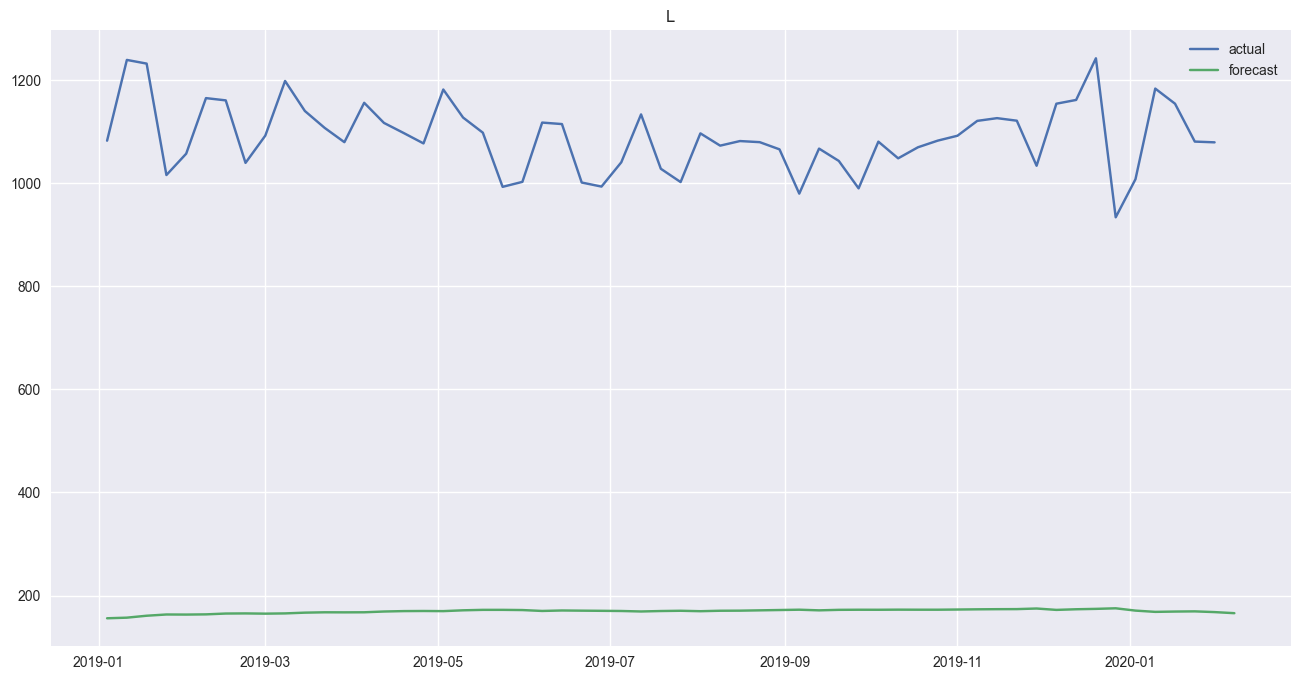

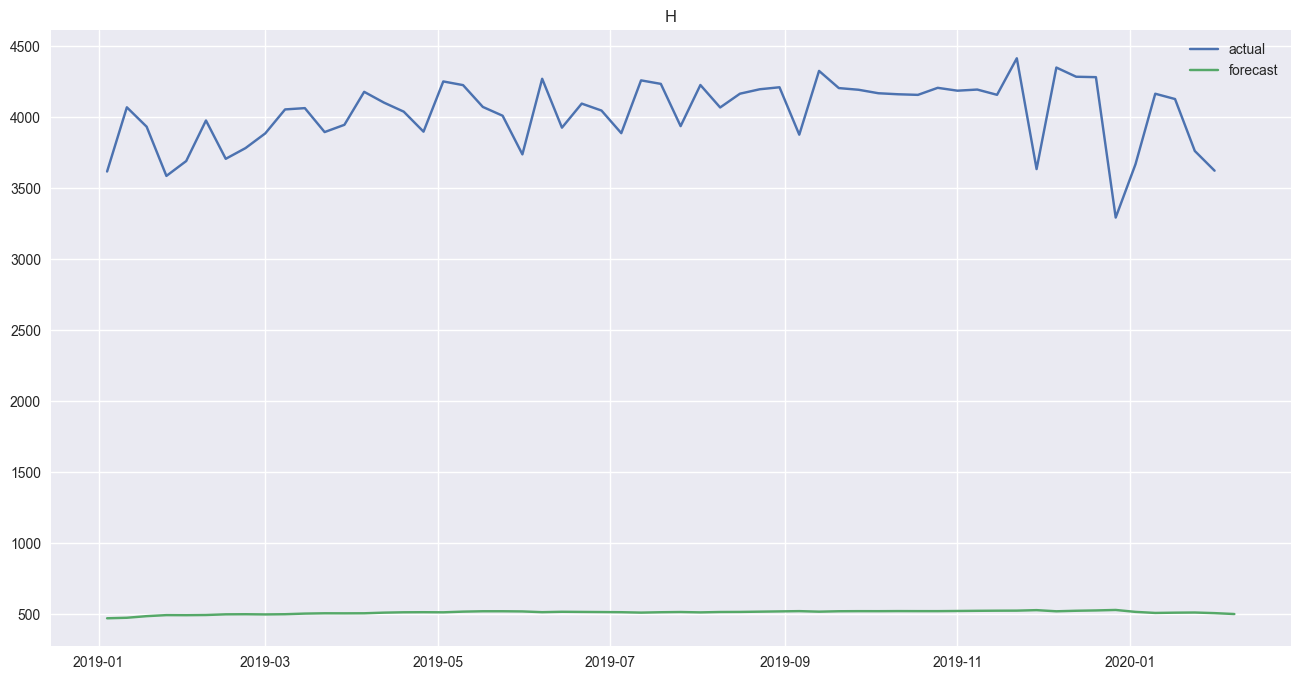

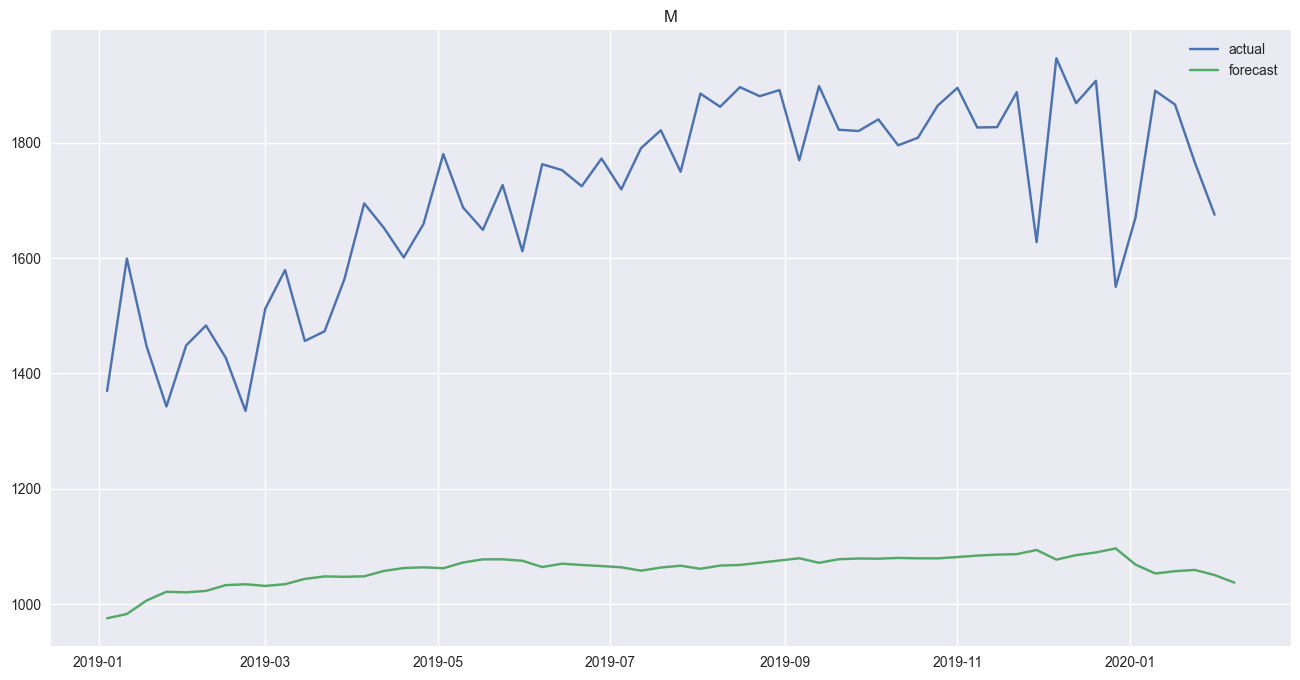

In [27]:
# plot data and predictions for each segment
for seg in segments:
    plt.plot(hierarchy_df[seg], label='actual')
    plt.plot(pred[seg], label='forecast')
    plt.title(seg)
    plt.legend()
    plt.show()

In [ ]:
# Remove all rows except last from pred
pred1 = pred.drop(['total', 'L', 'H', 'M', 'L_D', 'L_GP', 'L_NP', 'H_D', 'H_GP', 'H_NP', 'M_D', 'M_GP', 'M_NP'], axis=1)
pred1 = pred1.iloc[-1]
pred1 = pd.DataFrame(pred1)
pred1.reset_index(inplace=True)
pred1.columns = ['Physician_ID', 'Expected_TRx']
pred1['Physician_ID'] = pred1['Physician_ID'].apply(lambda x: x.split('_')[-1])
pred1.sort_values(by=['Physician_ID'], inplace=True)
pred1.reset_index(drop=True, inplace=True)
pred1

In [ ]:
pred1.to_csv('submission.csv', index=False)